Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/3
38/38 [==============================] - 435s 10s/step - loss: 0.2622 - accuracy: 0.8921 - val_loss: 0.1159 - val_accuracy: 0.9699
Epoch 2/3
38/38 [==============================] - 377s 10s/step - loss: 0.0693 - accuracy: 0.9808 - val_loss: 0.0862 - val_accuracy: 0.9799
Epoch 3/3
38/38 [==============================] - 412s 11s/step - loss: 0.0329 - accuracy: 0.9916 - val_loss: 0.0796 - val_accuracy: 0.9799
10/10 - 29s - loss: 0.0796 - accuracy: 0.9799 - 29s/epoch - 3s/step
Accuracy: 97.99%
Overall Loss: 0.08


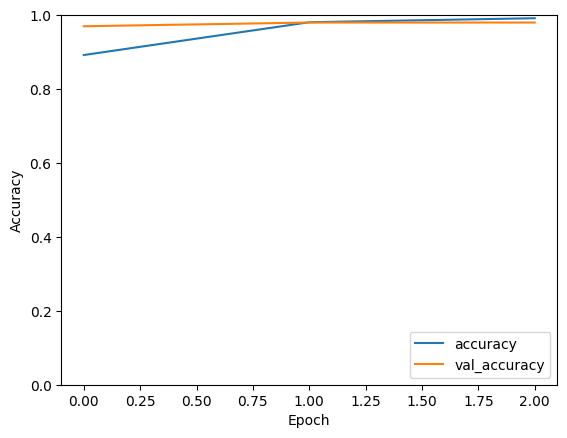

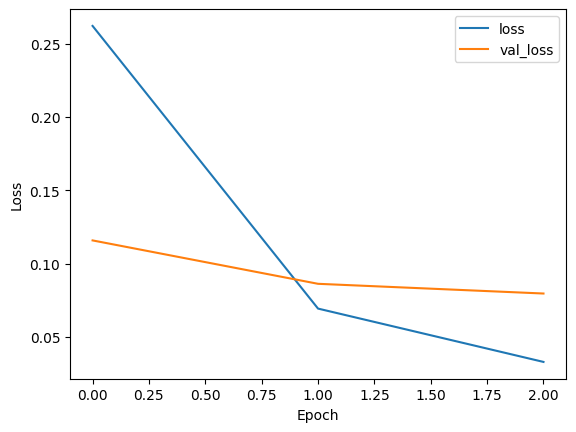

In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import TFAutoModel, AutoTokenizer, TFBertModel
from sklearn.utils import resample

device = tf.config.experimental.list_physical_devices('GPU')
if device:
    tf.config.experimental.set_memory_growth(device[0], True)


tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
data_set = pd.read_csv('spam.csv')



In [ ]:

data_set['spam'] = data_set['Category'].apply(lambda x: 1 if x == 'spam' else 0)

spam = data_set[data_set['Category'] == 'spam']
ham = data_set[data_set['Category'] == 'ham']


resampled_ham = resample(ham, replace=True, n_samples=len(spam), random_state=42)
resampled_data = pd.concat([resampled_ham, spam])


text = resampled_data['Message'].tolist()
labels = resampled_data['spam'].values
X_train, X_test, y_train, y_test = train_test_split(text, labels, stratify=labels, test_size=0.2, random_state=42)


In [15]:
train_output = tokenizer(X_train, padding=True, truncation=True, max_length=128, return_tensors='tf')
test_output = tokenizer(X_test, padding=True, truncation=True, max_length=128, return_tensors='tf')


train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_output), y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_output), y_test))

batch_size = 32
train_dataset = train_dataset.shuffle(len(train_dataset)).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Text: Ok lar... Joking wif u oni...
Probability: 0.5006
Predicted Label: spam

Text: This is a negative review.
Probability: 0.5041
Predicted Label: spam



In [ ]:
class SpamClassifier(tf.keras.Model):
    def __init__(self, **kwargs):
        super(SpamClassifier, self).__init__(**kwargs)
        self.bert = TFBertModel.from_pretrained('bert-base-uncased')
        self.dense = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        bert_output = self.bert(inputs)[1]
        return self.dense(bert_output)


model = SpamClassifier()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['accuracy'])


history = model.fit(train_dataset, epochs=3, validation_data=test_dataset)

# Evaluate the model
loss, accuracy = model.evaluate(test_dataset, verbose=2)
print(f'Accuracy: {accuracy*100:.2f}%')
print(f'Overall Loss: {loss:.2f}')

# Save the model architecture and weights
model_json = model.to_json()
with open("Sentiment_analysis.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("Sentiment_analysis_weights.h5")

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()